In [1]:
import numpy as np
import pandas as pd 
import scanpy as sc
import preprocess 
from sklearn import mixture
import mrf
import os 
import imp
from function import *

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_34476/2451052796.py:8: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
imp.reload(mrf)

<module 'mrf' from '/home/qinxianhan/project/spatial/Hidden_Markov_Random_Field/src/mrf.py'>

In [3]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(8,8))
import seaborn as sns

In [4]:
adata = sc.read_visium('../../dataset/goldStandard')
adata.var_names_make_unique()
adata = preprocess.data_preprocess(adata)

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
gmm = mixture.GaussianMixture(n_components=2)
coord = np.array(adata.obs.iloc[:,1:3])
target_list =['CAMK2N1', 'PCP4', 'NEFM', 'NEFH', 'B3GALT2']
target_gene =target_list[1]

In [6]:
beta =5
labels_list= mrf.mrf_process(adata, gene_id=target_gene, beta = beta,max_iteration=5e4)

[(-1, 1), (1, 1), (1, -1), (1, 1), (0, 2), (0, -2)]
77 121


100%|██████████| 50000/50000 [00:01<00:00, 40560.34it/s]

2573 pixels changed after 50000 iterations
[[-0.10145462  0.20003575]
 [ 0.42366984  0.96030328]]


In [7]:
beta = 3
labels_list_new= mrf.mrf_with_icmem(adata, gene_id = target_gene, beta = beta, max_iter = 10)

100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

[[ 9.53788610e-01  3.54916776e-01]
 [-8.70590508e-01  1.00000000e-05]]


In [8]:
exp = adata[:,target_gene].X.toarray()
gmm = mixture.GaussianMixture(n_components=2)
gmm.fit(exp)
gmm_labels = gmm.predict(exp)
gmm_labels = label_resort(gmm.means_, gmm_labels)

In [9]:
gmm.means_.reshape(-1), gmm.covariances_.reshape(-1)

(array([-0.87059051,  0.95385807]), array([1.00000000e-06, 3.54804567e-01]))

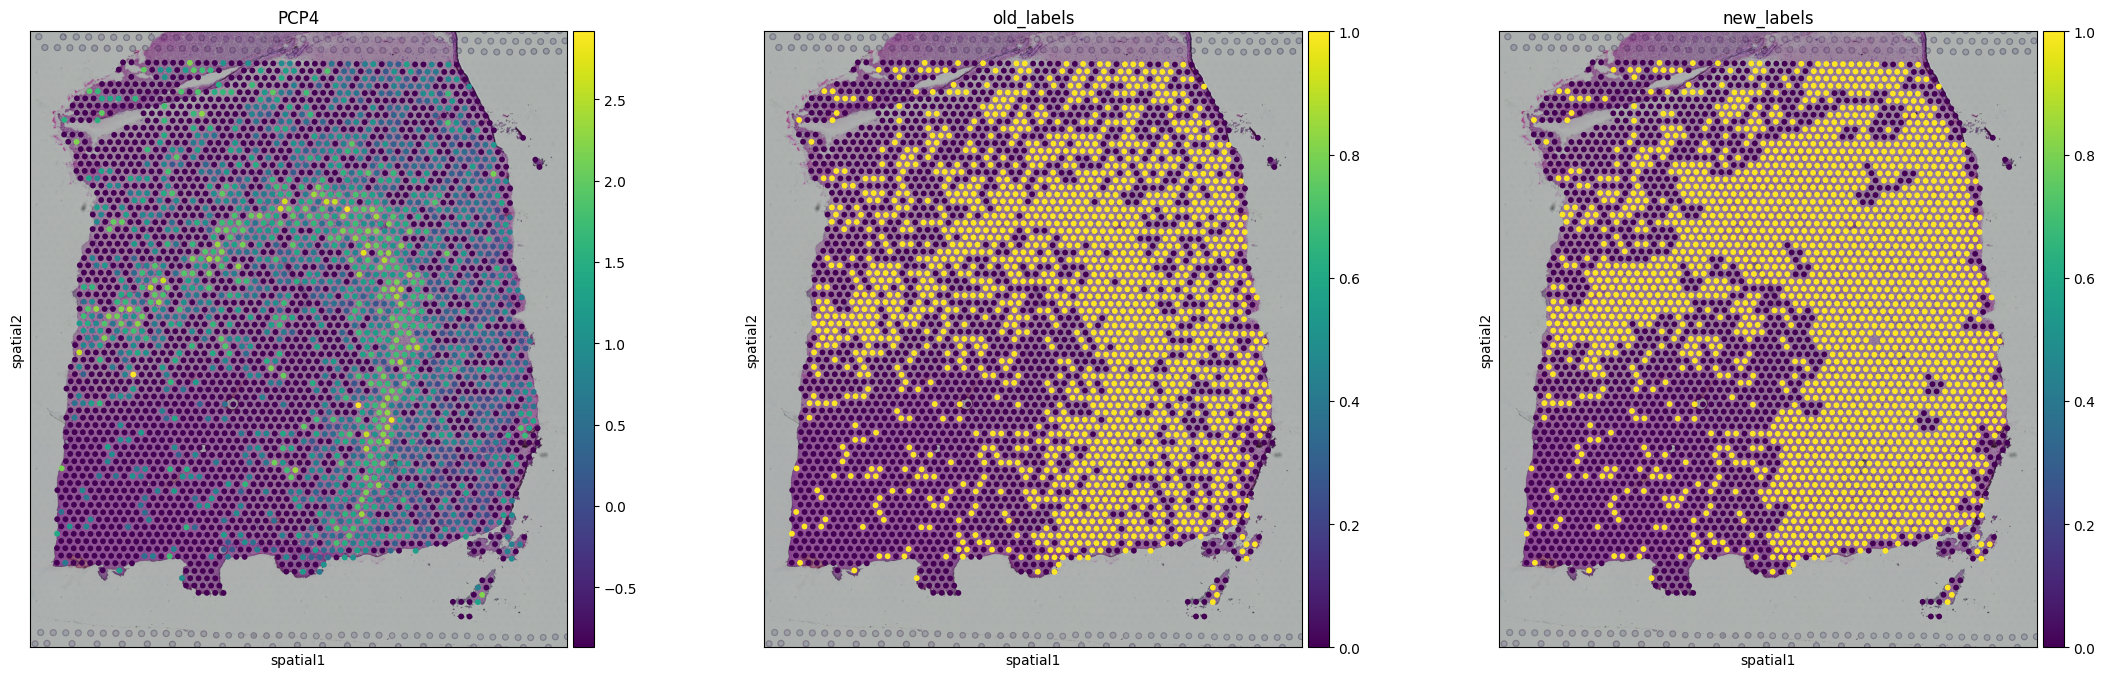

In [10]:
adata.obs['old_labels'] = gmm_labels
adata.obs['new_labels'] = labels_list_new
sc.pl.spatial(adata, color=[target_gene,'old_labels','new_labels'])